# Chapter 7 - Hipothesis & Inference

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import math
import random

### Statistical Hypothesis Testing

In [2]:
def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

Text(0.5, 1.0, 'Various Normal cdfs')

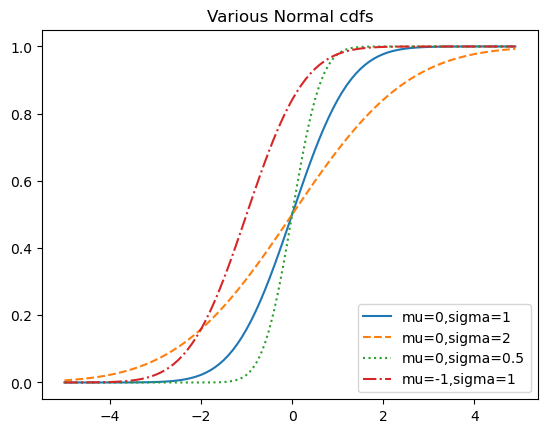

In [3]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_cdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_cdf(x,mu=-1) for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal cdfs")
# plt.show()

In [4]:
normal_probability_below = normal_cdf

In [5]:
def normal_probability_above(lo: float,
                             mu: float = 0,
                             sigma: float = 1) -> float:
    return 1 - normal_cdf(lo, mu, sigma)

In [6]:
def normal_probability_between(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    return normal_cdf(hi, mu,sigma) - normal_cdf(lo, mu, sigma)

In [7]:
def normal_probability_outside(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    return 1 - normal_probability_between(lo, hi, mu,sigma)

In [8]:
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

In [9]:
def normal_upper_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    return inverse_normal_cdf(probability, mu, sigma)

In [10]:
def normal_lower_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    return inverse_normal_cdf(1 - probability, mu, sigma)

In [11]:
def normal_two_sided_bounds(probability: float,
                            mu: float = 0,
                            sigma: float = 1) -> Tuple[float, float]:
    tail_probability = (1 - probability) / 2
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

In [12]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)

In [13]:
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)

In [14]:
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

In [15]:
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

In [16]:
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability

In [17]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)

In [18]:
type_2_probability = normal_probability_between(hi, mu_1, sigma_1)
power = 1 - type_2_probability

### p-Values

In [45]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    
    if x >= mu:
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        return 2 * normal_probability_below(x, mu, sigma)

In [46]:
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598835

In [47]:
extreme_value_count = 0
for _ in range(1000):
    num_heads = sum(1 if random.random() < 0.5 else 0
                    for _ in range(1000))
    if num_heads >= 530 or num_heads <= 470:
        extreme_value_count += 1
        
assert 59 < extreme_value_count < 65, f"{extreme_value_count}"

AssertionError: 57

In [48]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [49]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [50]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582072

In [51]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

### Confidence Intervals

In [52]:
p = 0.5

In [53]:
math.sqrt(p * (1 - p) / 1000)

0.015811388300841896

In [54]:
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)

In [55]:
normal_two_sided_bounds(0.94, mu, sigma)

(0.49529931353670487, 0.5547006864632952)

In [56]:
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
normal_two_sided_bounds(0.95, mu, sigma)

(0.5091095927295919, 0.5708904072704082)

### p-Hacking

In [57]:
from typing import List

In [58]:
def run_experiment() -> List[bool]:
    return [random.random() < 0.5 for _ in range(1000)]

In [59]:
def reject_fairness(experiment: List[bool]) -> bool:
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

assert num_rejections == 46

### Example: Running an A/B Test

In [60]:
def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [61]:
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [62]:
z = a_b_test_statistic(1000, 200, 1000, 180)
z

-1.1403464899034472

In [63]:
two_sided_p_value(z)

0.254141976542236

In [64]:
z = a_b_test_statistic(1000, 200, 1000, 150)
two_sided_p_value(z)

0.003189699706216853

### Bayesian Inference

In [65]:
def B(alpha: float, beta: float) -> float:
    return amth.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

In [69]:
def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

In [70]:
# alpha / (alpha + beta)